The Scraper for Financial News and Sentiment Score 

In [39]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Scraping 

In [40]:
#scrape data
url_1 = "https://finviz.com/quote.ashx?t="
news_tables = {}
# tickers = tickers_csv["Symbol"].tolist() #add csv for tickers
tickers = ['AMZN', 'TSLA', 'GOOG']
for ticker in tickers:
    url_2 = url_1 + ticker
    req =  Request(url = url_2, headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'})
    response = urlopen(req)
    #extract into html
    html = BeautifulSoup(response)
    #find and load news_table
    news_table = html.find(id = 'news-table')
    #add table to dictionary
    news_tables[ticker] = news_table

In [41]:
amzn = news_tables['AMZN']
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
 # Read the text of the element ‘a’ into ‘link_text’
 a_text = table_row.a.text
 # Read the text of the element ‘td’ into ‘data_text’
 td_text = table_row.td.text
 # Print the contents of ‘link_text’ and ‘data_text’ 
 print(a_text)
 print(td_text)
 # Exit after printing 4 rows of data
 if i == 7:
    break

Amazon, Facing Questions Over Workplace Safety, Also Probed on Bank Dealings
Jan-20-23 08:06PM
Weekly Roundup
06:35PM
Amazon's Alexa Smart Speaker Blazed A Trail, Then Burned Out
04:38PM
Walmart Has a Unique Solution to Retail's Biggest Problem
03:43PM
Why Media-Streaming Stocks Stole the Show on Friday
03:04PM
Exclusive: How Amazon Fresh's 'zombie' store trend may hurt Orlando shopping centers
02:03PM
Amazon's AWS to invest $35 billion in Virginia
12:51PM
UPDATE 2-Amazon's AWS to invest $35 bln in Virginia
12:44PM


In [42]:
parsed_news = []
#news iteration
for file_name, news_table in news_tables.items():
    #iterate through all tr tags
    for x in news_table.findAll('tr'):
        text = x.a.get_text() #read text from each a tag under tr tag
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0] #to make sure all news time for a given date is taken
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, text])


parsed_news[:5]


[['AMZN',
  'Jan-20-23',
  '08:06PM',
  'Amazon, Facing Questions Over Workplace Safety, Also Probed on Bank Dealings'],
 ['AMZN', 'Jan-20-23', '06:35PM', 'Weekly Roundup'],
 ['AMZN',
  'Jan-20-23',
  '04:38PM',
  "Amazon's Alexa Smart Speaker Blazed A Trail, Then Burned Out"],
 ['AMZN',
  'Jan-20-23',
  '03:43PM',
  "Walmart Has a Unique Solution to Retail's Biggest Problem"],
 ['AMZN',
  'Jan-20-23',
  '03:04PM',
  'Why Media-Streaming Stocks Stole the Show on Friday']]

In [43]:
#converting into a DataFrame

columns = ['ticker', 'date', 'time', 'headline']
news_df = pd.DataFrame(parsed_news, columns=columns)
news_df


,ticker,date,time,headline
0,AMZN,Jan-20-23,08:06PM,"Amazon, Facing Questions Over Workplace Safety..."
1,AMZN,Jan-20-23,06:35PM,Weekly Roundup
2,AMZN,Jan-20-23,04:38PM,"Amazon's Alexa Smart Speaker Blazed A Trail, T..."
3,AMZN,Jan-20-23,03:43PM,Walmart Has a Unique Solution to Retail's Bigg...
4,AMZN,Jan-20-23,03:04PM,Why Media-Streaming Stocks Stole the Show on F...
...,...,...,...,...
295,GOOG,Dec-15-22,04:14PM,Amazon goes TikTok. Here's how it will work.
296,GOOG,Dec-15-22,12:52PM,Google is not releasing its AI bot competitor ...
297,GOOG,Dec-15-22,12:05PM,Why Alphabet Stock Was Sliding Today
298,GOOG,Dec-15-22,10:06AM,ChatGPT owner OpenAI projects $1 billion in re...


Sentiment Analysis

In [44]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rajarshibhattacharjee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [45]:
vader = SentimentIntensityAnalyzer()
#to get polarity scores from the headlines
scores = news_df['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)
news_df = news_df.join(scores_df, rsuffix = '_right')
news_df['date'] = pd.to_datetime(news_df.date).dt.date #to convert date column to datetime format

news_df.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2023-01-20,08:06PM,"Amazon, Facing Questions Over Workplace Safety...",0.000,0.667,0.333,0.5423
1,AMZN,2023-01-20,06:35PM,Weekly Roundup,0.000,1.000,0.000,0.0000
2,AMZN,2023-01-20,04:38PM,"Amazon's Alexa Smart Speaker Blazed A Trail, T...",0.000,0.748,0.252,0.4019
3,AMZN,2023-01-20,03:43PM,Walmart Has a Unique Solution to Retail's Bigg...,0.245,0.545,0.209,-0.1027
4,AMZN,2023-01-20,03:04PM,Why Media-Streaming Stocks Stole the Show on F...,0.000,1.000,0.000,0.0000


<ipython-input-46-d4a6672fddc9>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = news_df.groupby(['ticker', 'date']).mean()


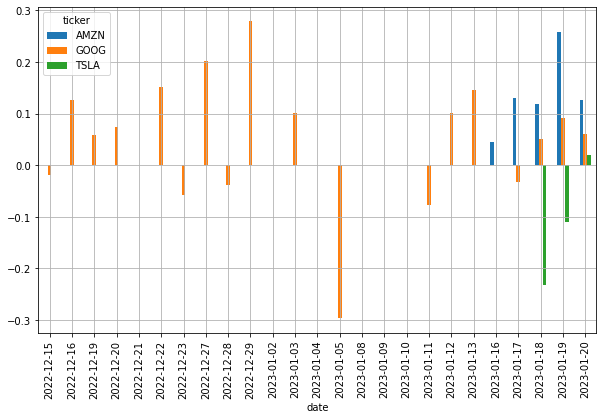

In [46]:
#basic plotting
plt.rcParams['figure.figsize'] = [10, 6]
mean_scores = news_df.groupby(['ticker', 'date']).mean()

mean_scores = mean_scores.unstack() #unstacking the mean

mean_scores = mean_scores.xs('compound', axis = "columns").transpose()

mean_scores.plot(kind = 'bar')
plt.grid()

